# About this notebook 

The common missing link prediction benchmark is a classification task, where an algorithm is given a set of node pairs and *classifies* them into connected and unconnected node pairs. In practical applications, however, the missing link prediction is a *search* problem, i.e., given a network, we want an algorithm to provide a ranking of node pairs that are likely to be connected.
Because of the misalignment in the objectives, an algorithm that performs well on the benchmark may not necessarily perform well in practical applications.

In this notebook, we will showcase the problem by using a small network, *political blog network*.

# Set up

Follow the `Installation` section and make sure that all packages are installed including our packages under `./libs` 

In [1]:
from scipy import sparse 
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm.auto import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt 

# In-house 
from linkpred.LinkPredictionDataset import LinkPredictionDataset
import embcom 

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ignore this message if you do not use Glove. Otherwise, install glove python package by 'pip install glove_python_binary' 


# Experiment

### Generating the link prediction dataset from a network

In [2]:
network_name = "polblog"

# Load the edge table
edge_table = pd.read_csv(f"../../test_data/derived/networks/raw/{network_name}/edge_table.csv", dtype = {"src":int, "trg":int})

# Construct the adjacency matrix in form of scipy sparse matrix
n_nodes = edge_table[["src", "trg"]].max().max() + 1
net = sparse.csr_matrix((np.ones(edge_table.shape[0]), (edge_table["src"], edge_table["trg"])), shape=(n_nodes, n_nodes)) 

# Construct the link prediction benchmark 
lpmodel = LinkPredictionDataset(testEdgeFraction = 0.5, negative_edge_sampler = "uniform")
lpmodel.fit(net)
train_net, test_edge_table = lpmodel.transform()

# Ensure that the network is undirected and unweighted
train_net = train_net + train_net.T 
train_net.data = train_net.data * 0 + 1
train_net.eliminate_zeros() 

# test net: the adjacency matrix in scipy csr sparse matrix format
# test_edge_table: table of connected and unconnected node pairs. pandas.DataFrame. 

100%|██████████| 8359/8359 [00:00<00:00, 14150.66it/s]


### Link prediction models 

Based on embedding 

In [3]:
embedding_models = {}
embedding_model = lambda f: embedding_models.setdefault(f.__name__, f)

def calc_prediction_score_embedding_model(network, pred_model, dim = 64):
    emb = pred_model(network, dim)

    # For graph embedding based on word2vec, we use the probability P(i,j) of 
    # random walks moving from i to j, instead of the dot similarity. 
    # The P(i,j) is given by
    #    P(i,j) \propto \exp(u[i]^\top u[j] + \ln p0[i] + \ln p0[j])
    # where p0 is proportional to the degree. In residual2vec paper, 
    # we found that P(i,j) is more predictable of missing edges than 
    # the dot similarity u[i]^\top u[j]. 
    if pred_model.__name__ in ["node2vec", "deepwalk", "line"]:
        deg = np.array(network.sum(axis = 1)).reshape(-1)
        deg = np.maximum(deg, 1) 
        deg = deg/np.sum(deg)
        return (emb @ emb.T) + np.add.outer(np.log(deg), np.log(deg))
    else:
        return emb @ emb.T

@embedding_model
def node2vec(network, dim, window_length=5, num_walks=20):
    model = embcom.embeddings.Node2Vec(window_length=window_length, num_walks=num_walks)
    model.fit(network)
    return model.transform(dim=dim)

@embedding_model
def line(network, dim, num_walks=20):
    model = embcom.embeddings.Node2Vec(window_length=1, num_walks=num_walks)
    model.fit(network)
    return model.transform(dim=dim)


@embedding_model
def deepwalk(network, dim, window_length=5, num_walks=20):
    model = embcom.embeddings.DeepWalk(window_length=window_length, num_walks=num_walks)
    model.fit(network)
    return model.transform(dim=dim)


@embedding_model
def leigenmap(network, dim):
    model = embcom.embeddings.LaplacianEigenMap()
    model.fit(network)
    return model.transform(dim=dim)


Based on the network topology 

In [4]:
topology_models = {}
topology_model = lambda f: topology_models.setdefault(f.__name__, f)

def calc_prediction_score_topology_model(network, pred_model):
    src, trg = np.triu_indices(network.shape[0], k = 1)
    score = pred_model(network, src, trg) 
    S = np.zeros(net.shape)
    S[(src,trg)] = score
    S = S + S.T
    return S

@topology_model
def preferentialAttachment(network, src, trg):
    deg = np.array(network.sum(axis=1)).reshape(-1)
    return deg[src] * deg[trg]


@topology_model
def commonNeighbors(network, src, trg):
    return np.array((network[src, :].multiply(network[trg, :])).sum(axis=1)).reshape(-1)


@topology_model
def jaccardIndex(network, src, trg):
    deg = np.array(network.sum(axis=1)).reshape(-1)
    score = np.array((network[src, :].multiply(network[trg, :])).sum(axis=1)).reshape(
        -1
    )
    return score / np.maximum(deg[src] + deg[trg] - score, 1)


@topology_model
def resourceAllocation(network, src, trg):
    deg = np.array(network.sum(axis=1)).reshape(-1)
    deg_inv = 1 / np.maximum(deg, 1)
    deg_inv[deg == 0] = 0
    return np.array(
        ((network[src, :] @ sparse.diags(deg_inv)).multiply(network[trg, :])).sum(
            axis=1
        )
    ).reshape(-1)


@topology_model
def adamicAdar(network, src, trg):
    deg = np.array(network.sum(axis=1)).reshape(-1)
    log_deg_inv = 1 / np.maximum(np.log(np.maximum(deg, 1)), 1)
    log_deg_inv[deg == 0] = 0
    return np.array(
        ((network[src, :] @ sparse.diags(log_deg_inv)).multiply(network[trg, :])).sum(
            axis=1
        )
    ).reshape(-1)

### Training & Prediction 

In [5]:
PredScore = {}
for model_name, pred_model in embedding_models.items():
    PredScore[model_name] = calc_prediction_score_embedding_model(train_net, pred_model)

for model_name, pred_model in topology_models.items():
    PredScore[model_name] = calc_prediction_score_topology_model(train_net, pred_model)

### Evaluation: Classification problem

Let us evaluate the link prediction algorithms based on the perspective of prediction as classification. In this perspective, the predictability of missing edges is tested by comparing the prediction scores for a *given set* of existent and non-existent edges. 
The existent edges (i.e., positive examples) are sampled from the set of edges in a given network uniformly at random. The non-existent edges (i.e., negative examples) are sampled from a set of unconnected node pairs uniformly at random. A good algorithm should assign a higher score for existent edges over the non-existent edges. 


In [6]:
# The existent and non-existent edges are in test_edge_table

# y = 1 for existent edges. y = 0 for non-existent edges.
y = test_edge_table["isPositiveEdge"].values 

# The ids of nodes in each pair
src_test, trg_test = test_edge_table["src"].values, test_edge_table["trg"].values  

# Evaluation
result_aucroc_table = []
for model_name, S in PredScore.items():

    # Retrieve the prediction score for the test node pairs 
    ypred = S[(src_test, trg_test)]

    # Calculate the separation of the distributions of the prediction scores 
    # for existent and non-existent edges
    aucroc = roc_auc_score(y, ypred)
    result_aucroc_table+= [{"AUC-ROC":aucroc, "Model":model_name}]

# To pandas.DataFrame
result_aucroc_table = pd.DataFrame(result_aucroc_table)

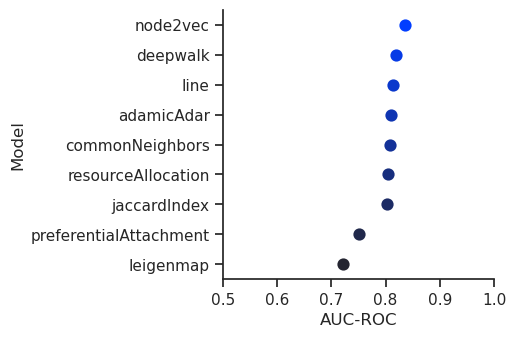

In [41]:
sns.set_style('white')
sns.set(font_scale=1)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3.5,3.5))

ax = sns.pointplot(data = result_aucroc_table.sort_values(by = "AUC-ROC", ascending = False), x = "AUC-ROC", y = "Model", hue = "AUC-ROC", color = sns.color_palette("bright")[0], join=False)
ax.legend().remove()
ax.set_xlim(0.5, 1.0)
sns.despine()
#fig.savefig(output_file, bbox_inches='tight', dpi=300)

### Evaluation: Search problem

Let us evaluate the link prediction algorithms by considering link prediction as search. In this perspective, we ask the algorithms to provide a list of the most probable edges and evaluate how many node edges exist in the provided list. We evaluate the predicitons based on the average precision rate. 

In [13]:
# y = 1 for existent edges. y = 0 for non-existent edges.
y = test_edge_table["isPositiveEdge"].values
src_test, trg_test = test_edge_table["src"].values, test_edge_table["trg"].values  

# Create a matrix Y, where Y[i,j] = 1 if (i,j) have an edge in the test set 
isPositive = y > 0 # since only positives matter in ranking  
src_test_pos, trg_test_pos = src_test[isPositive], trg_test[isPositive]
Y = sparse.csr_matrix((np.ones_like(src_test_pos), (src_test_pos, trg_test_pos)), shape=net.shape)
Y = Y + Y.T 
Y.data = Y.data * 0 + 1

# Edges in the train net will be excluded from the ranking
src_train, trg_train, _ = sparse.find(train_net)

# Evaluation
n_prediction = 1000 
result_ave_prec_table = []
for model_name, S in PredScore.items():

    # Prep.
    S = S.copy() # To prevent S from being overwritten. 
    S[(src_train,trg_train)] = -np.inf # Prevent the train edges from entering the ranking

    # Find the most probably edges 
    _src, _trg = np.triu_indices(S.shape[0], k = 1)
    indices = np.argsort(-S[(_src, _trg)])[:n_prediction]
    src_pred, trg_pred = _src[indices], _trg[indices]
    ypred = S[(src_pred, trg_pred)]

    # Get the positives in the ranking 
    y = np.array(Y[(src_pred, trg_pred)]).reshape(-1) # positive

    # Calculate the separation of the distributions of the prediction scores 
    # for existent and non-existent edges
    ave_prec = average_precision_score(y, ypred)
    result_ave_prec_table+= [{"Average Precision":ave_prec, "Model":model_name}]

# To pandas.DataFrame
result_ave_prec_table = pd.DataFrame(result_ave_prec_table)

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


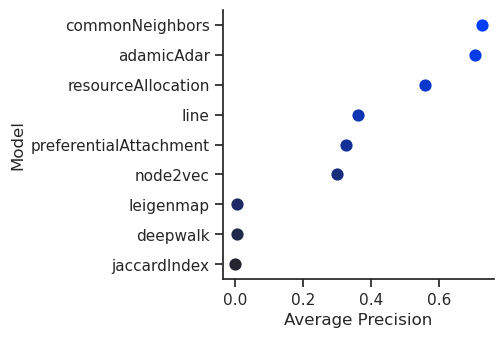

In [44]:
sns.set_style('white')
sns.set(font_scale=1)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3.5,3.5))

ax = sns.pointplot(data = result_ave_prec_table.sort_values(by = "Average Precision", ascending = False), x = "Average Precision", y = "Model", hue = "Average Precision", color = sns.color_palette("bright")[0], join=False)
ax.legend().remove()
sns.despine()

Summary

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


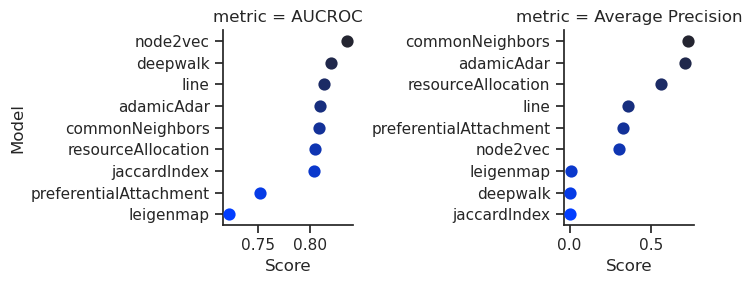

In [64]:
sns.set_style('white')
sns.set(font_scale=1)
sns.set_style('ticks')
df, dg = result_aucroc_table.copy(), result_ave_prec_table.copy()
df = df.rename(columns = {"AUC-ROC":"Score"})
dg = dg.rename(columns = {"Average Precision":"Score"})
df["metric"] = "AUCROC"
dg["metric"] = "Average Precision"
data_table = pd.concat([df, dg])

g = sns.FacetGrid(data = data_table.sort_values(by = "Score", ascending = False), col = "metric", height = 3, aspect = 1.2, sharey = False, sharex=False)
g.map(sns.pointplot, "Score", "Model", "Model", color = sns.color_palette("bright")[0], join = False)

# Discussion 

### Comparison 
The classification and search tasks do not agree with each other in terms of the ranking of the algorithms. For example, node2vec is the best algorithm for the classification while it is ranked at the fifth out of the nine algorithms in the search task, with the predictability of missing edges worse than the preferential attachment, a far simpler prediction model. 

The disagreement between two benchmarks is mainly because of how false positives are evaluated. A false positive occurs when the algorithm identifies two nodes as likely to be connected when they are not. The prediction score is usually skewed towards the left, with only a small fraction of nodes having high scores, while the majority have comparable scores. The key difference between the benchmarks is that strong false positives always impact search performance since edge ranking is based on scores. However, in classification, these strong false positives are less likely to be reflected because they are only a few fraction of the huge number of unconnected node pairs.

While the search task aligns more closely with the practical use of link prediction algorithms, identifying false positives in this task can be computationally intensive. This is because it involves calculating and ranking prediction scores for all possible pairs of nodes, which can be a significant challenge when dealing with large networks and algorithms that require heavy computations.